In [ ]:
#Import statements
import os
import numpy as np
from sklearn import linear_model, preprocessing, pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as thdat
import functools
from collections import Counter

#GPU
device = ("cuda" if torch.cuda.is_available() else "cpu")

#Importing Necessary Dataset
!git clone https://github.com/SaybrookMenace/volcanoesOnVenus.git
import sys
sys.path.insert(0, "/volcanoData")



Cloning into 'volcanoesOnVenus'...
remote: Enumerating objects: 426, done.
remote: Counting objects: 100% (426/426), done.
remote: Compressing objects: 100% (412/412), done.
remote: Total 426 (delta 22), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (426/426), 129.69 MiB | 2.66 MiB/s, done.
Resolving deltas: 100% (22/22), done.
Updating files: 100% (412/412), done.


In [ ]:
# Making a table of values, in the following structure:
# 2d List, with 1st Column: Image #; 2nd, Volcano Scale of 1-4; 3rd and 4th, X,Y; and 5th, Radius
# The 6th is unique id of each volcano
GroundTruths = []

# Directory containing the .lxyr files
directory = "volcanoesOnVenus/"

id = 1

for i in range(1, 135):

  filename = directory + "img" + str(i) + ".lxyr"

  if os.stat(filename).st_size == 0:
        print(f"Skipping empty file: {filename}")
        continue
  else:
    with open(filename, "r") as f:
      for lines in f.readlines():
        line = lines.split(' ')
        GroundTruths.append([i, float(line[0]), float(line[1]), float(line[2]), float(line[3]), id])
        id += 1

GroundTruths = np.array(GroundTruths)

Skipping empty file: volcanoesOnVenus/img5.lxyr
Skipping empty file: volcanoesOnVenus/img85.lxyr
Skipping empty file: volcanoesOnVenus/img86.lxyr
Skipping empty file: volcanoesOnVenus/img91.lxyr
Skipping empty file: volcanoesOnVenus/img93.lxyr
Skipping empty file: volcanoesOnVenus/img99.lxyr
Skipping empty file: volcanoesOnVenus/img100.lxyr
Skipping empty file: volcanoesOnVenus/img102.lxyr
Skipping empty file: volcanoesOnVenus/img106.lxyr
Skipping empty file: volcanoesOnVenus/img107.lxyr
Skipping empty file: volcanoesOnVenus/img114.lxyr
Skipping empty file: volcanoesOnVenus/img116.lxyr
Skipping empty file: volcanoesOnVenus/img117.lxyr
Skipping empty file: volcanoesOnVenus/img120.lxyr
Skipping empty file: volcanoesOnVenus/img127.lxyr
Skipping empty file: volcanoesOnVenus/img128.lxyr


In [ ]:
print(GroundTruths[:5])

[[  1.         1.       293.       794.        21.93       1.      ]
 [  1.         1.       232.       654.        32.98       2.      ]
 [  1.         1.       331.       696.        23.540001   3.      ]
 [  1.         1.       349.       776.        16.969999   4.      ]
 [  1.         2.       353.       764.        12.04       5.      ]]


In [ ]:
# Alright! As of this point, all the ground truth files are read into a single array.
smallVolcanoes = 0
largeVolcanoes = 0

for volcano in GroundTruths:
  if volcano[4] < 15:
    smallVolcanoes += 1
  else:
    largeVolcanoes += 1

print("Small Volcanoes: " + str(smallVolcanoes))
print("Large Volcanoes: " + str(largeVolcanoes))

Small Volcanoes: 789
Large Volcanoes: 731


In [ ]:
# Time to read in actual raw volcano data:
rawVolcanoData = []

for i in range(1, 135):
  filename = directory + "img_text_file" + str(i) + ".txt"
  rawData = []
  with open(filename, "r") as f:
    for lines in f.readlines():
      line = [int(x) for x in lines.strip().split(',')]
      rawData.append(line)
  rawVolcanoData.append(rawData)

print(len(rawVolcanoData))

134


In [ ]:
# making sure this works:
print(rawVolcanoData[0][0][1023])

117


In [ ]:
# Wonderful! We have now an array of 2d arrays, each describing an image.
# Time to crop these images into the actual volcanoes

'''
FYI: cropVolcanoes has several stats ---
Column 1: Image ID (corresponds to ID of GroundTruths list)
Column 2: Likelihood of Volcano, 1-4
Column 3: Radius of Volcano
Column 4: numpy 2d array of cropped image
'''

cropVolcanoes = []
currImg = 1
curVolcano = np.array(rawVolcanoData[0])

# First, go through all rows of groundTruths:
for volcano in GroundTruths:
  newVolcano = [volcano[5], volcano[1], volcano[4]]
  if(currImg != int(volcano[0])):
    currImg = int(volcano[0])
    curVolcano = np.array(rawVolcanoData[currImg - 1])

  # Crop from original photo
  newVolcano.append(curVolcano[int(volcano[3]-volcano[4])-1:int(volcano[3]+volcano[4])+1,int(volcano[2]-volcano[4])-1:int(volcano[2]+volcano[4])+1])
  cropVolcanoes.append(newVolcano)

# That should be done! let's check.

In [ ]:
def normalize_grayscale(img_array):
    """Normalizes a grayscale image array to the range [0, 1]."""
    if img_array.size == 0:
        return img_array
    min_val = np.min(img_array)
    max_val = np.max(img_array)
    return (img_array - min_val) / (max_val - min_val)

In [ ]:
print(len(cropVolcanoes)) # Alright, all 1520 GroundTruths are here
print(cropVolcanoes[0]) # The structure of the item is right
print(cropVolcanoes[1]) # The id of the item is stored correctly
print(cropVolcanoes[2][3].shape) # The shape of the volcano is a square (yay!)
print(cropVolcanoes[:10])

1520
[1.0, 1.0, 21.93, array([[ 95, 103, 100, ..., 107, 100,  96],
       [ 94,  94,  96, ...,  93,  94, 104],
       [ 97,  75,  95, ...,  90,  92,  88],
       ...,
       [119, 134, 122, ..., 105, 113, 116],
       [125, 134, 130, ..., 106, 118, 101],
       [119, 131, 137, ..., 101, 103,  99]])]
[2.0, 1.0, 32.98, array([[ 99,  88,  97, ..., 123, 111, 118],
       [102,  96,  98, ..., 123, 123, 130],
       [102,  99, 101, ..., 125, 123, 133],
       ...,
       [ 72, 121, 123, ..., 110, 103, 111],
       [ 82, 103,  92, ..., 109, 100,  96],
       [100, 100, 104, ..., 106, 113, 102]])]
(49, 49)
[[1.0, 1.0, 21.93, array([[ 95, 103, 100, ..., 107, 100,  96],
       [ 94,  94,  96, ...,  93,  94, 104],
       [ 97,  75,  95, ...,  90,  92,  88],
       ...,
       [119, 134, 122, ..., 105, 113, 116],
       [125, 134, 130, ..., 106, 118, 101],
       [119, 131, 137, ..., 101, 103,  99]])], [2.0, 1.0, 32.98, array([[ 99,  88,  97, ..., 123, 111, 118],
       [102,  96,  98, ..., 123, 1

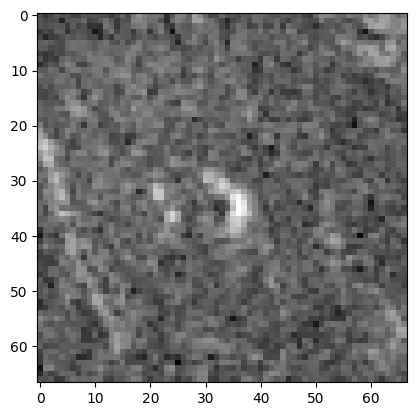

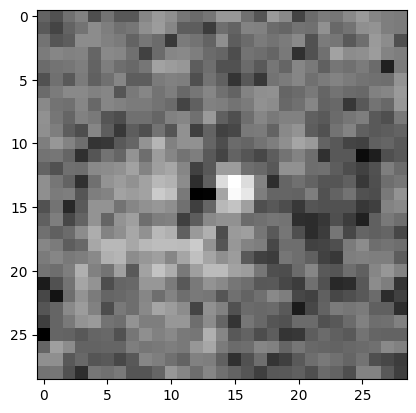

In [ ]:
# Test if the images were actually images (cropped correctly)
# Check with two random volcanoes
img = cropVolcanoes[1][3]
plt.imshow(img, cmap='gray')
plt.show()
img = normalize_grayscale(cropVolcanoes[1023][3])
plt.imshow(img, cmap='gray')
plt.show()

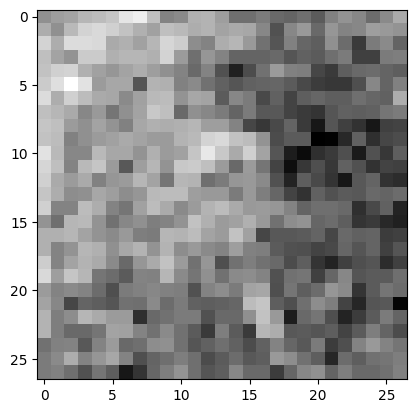

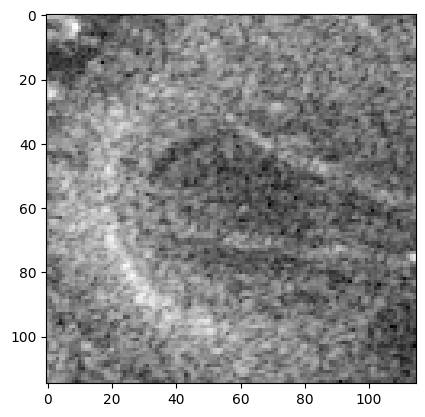

In [ ]:
#Yay! This actually looks somewhat like a volcano.

# Sort the volcanoes now
sortedVolcanoes = sorted(cropVolcanoes, key=lambda x: x[2])
img = normalize_grayscale(sortedVolcanoes[700][3])
plt.imshow(img, cmap='gray')
plt.show()
img = normalize_grayscale(sortedVolcanoes[1510][3])
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
#Let's create a plot describing our data for the presentation
sizes = [volcano[2] for volcano in sortedVolcanoes]
plt.figure(figsize=(10, 6))
plt.hist(sizes, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Volcano Sizes in Dataset')
plt.xlabel('Radius')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
'''
PART 2 ======================== MAKING THE NEURAL NETWORK ==============================
'''
# Import Statements
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Setting the random seed
torch.manual_seed(1234)

# Preprocessing
class GrayVolcanoes(Dataset):
  def __init__(self, matrices, labels, target_size):
    self.matrices = matrices
    self.labels = labels
    self.target_size = target_size
    self.transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert a single-channel tensor/array to PIL Image
        transforms.Resize(target_size),  # Resize to target dimensions
        transforms.ToTensor(),  # Convert back to tensor, scaling to [0, 1]
    ])

  def __len__(self):
    return len(self.matrices)

  def __getitem__(self, idx):
    matrix = self.matrices[idx]
    label = self.labels[idx]
    # Convert to tensor and apply transforms
    tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    transformed_tensor = self.transform(tensor)
    return transformed_tensor, torch.tensor(label, dtype=torch.long)

In [ ]:
# Largest cropped photo is (177, 177)
matrices = []
labels = []
for volcano in sortedVolcanoes:
  matrices.append(volcano[3])
  labels.append(volcano[1])
target_size = (177, 177)

# Create the dataset and DataLoader
dataset = GrayVolcanoes(matrices, labels, target_size)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Inspect a batch
for inputs, labels in dataloader:
    print("Batch Inputs Shape:", inputs.shape)
    print("Batch Labels:", labels)

Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([3, 3])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([3, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([4, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([3, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([4, 3])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([3, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([1, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([2, 1])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([2, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([1, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([4, 2])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: tensor([3, 4])
Batch Inputs Shape: torch.Size([2, 1, 177, 177])
Batch Labels: t

In [ ]:
#Divide the images into three bins (small, medium, large sizes) so that we can make three models.

#Get three "thirdtiles" to evenly divide data
side_lengths = [volcano[3].shape[0] for volcano in sortedVolcanoes]

sm_bin = []
sm_bin_labels = []
sm_bin_upper = np.percentile(side_lengths, 33)
sm_bin_upper = int(round(sm_bin_upper / 8)) * 8 #round to nearest multiple of 8 for easy nn arch

med_bin = []
med_bin_labels = []
med_bin_upper = np.percentile(side_lengths, 67)
med_bin_upper = int(round(med_bin_upper / 8)) * 8 #round to nearest multiple of 8 for easy nn arch

lg_bin = []
lg_bin_labels = []
lg_bin_upper = 177
lg_bin_upper = int(round(lg_bin_upper / 8)) * 8 #round to nearest multiple of 8 for easy nn arch

#sort image mats and labels into bins
for volcano in sortedVolcanoes:
  img_side_len = volcano[3].shape[0]

  if img_side_len < sm_bin_upper:
    sm_bin.append(volcano[3])
    sm_bin_labels.append(volcano[1])

  elif img_side_len <= med_bin_upper:
    med_bin.append(volcano[3])
    med_bin_labels.append(volcano[1])

  else:
    lg_bin.append(volcano[3])
    lg_bin_labels.append(volcano[1])

#split into 3 datasets
batch_sz = 32

X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(sm_bin, sm_bin_labels, test_size=0.2)
sm_train_dataset = GrayVolcanoes(X_sm_train, y_sm_train, (sm_bin_upper, sm_bin_upper))
sm_test_dataset = GrayVolcanoes(X_sm_test, y_sm_test, (sm_bin_upper, sm_bin_upper))
sm_train_dataloader = DataLoader(sm_train_dataset, batch_size=batch_sz, shuffle=True)
sm_test_dataloader = DataLoader(sm_test_dataset, batch_size=batch_sz, shuffle=False)

X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(med_bin, med_bin_labels, test_size=0.2)
med_train_dataset = GrayVolcanoes(X_med_train, y_med_train, (med_bin_upper, med_bin_upper))
med_test_dataset = GrayVolcanoes(X_med_test, y_med_test, (med_bin_upper, med_bin_upper))
med_train_dataloader = DataLoader(med_train_dataset, batch_size=batch_sz, shuffle=True)
med_test_dataloader = DataLoader(med_test_dataset, batch_size=batch_sz, shuffle=False)

X_lg_train, X_lg_test, y_lg_train, y_lg_test = train_test_split(lg_bin, lg_bin_labels, test_size=0.2)
lg_train_dataset = GrayVolcanoes(X_lg_train, y_lg_train, (lg_bin_upper, lg_bin_upper))
lg_test_dataset = GrayVolcanoes(X_lg_test, y_lg_test, (lg_bin_upper, lg_bin_upper))
lg_train_dataloader = DataLoader(lg_train_dataset, batch_size=batch_sz, shuffle=True)
lg_test_dataloader = DataLoader(lg_test_dataset, batch_size=batch_sz, shuffle=False)

print(f'The distribution of images in the small, medium, and large bins are:{len(sm_bin)}, {len(med_bin)}, {len(lg_bin)}, respectively')


The distribution of images in the small, medium, and large bins are:501, 451, 568, respectively


In [ ]:
'''
CNN Architecture
'''

class NeuralNet(nn.Module):
  def __init__(self, img_dim, num_classes, addl_layer = False):
    super(NeuralNet, self).__init__()
    #Convolution layers
    if addl_layer:
      self.convolutional_neural_network_layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
      )

    else:
      self.convolutional_neural_network_layers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
      )

    #Flattened num features using temp instance
    with torch.no_grad():
      temp_input = torch.zeros(1, 1, img_dim, img_dim)
      temp_out = self.convolutional_neural_network_layers(temp_input)
      flattened_num_features = temp_out.shape[1] * temp_out.shape[2] * temp_out.shape[3]

    #Linear layer
    self.linear_layers = nn.Sequential(
        nn.Linear(flattened_num_features, out_features=64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=64, out_features=num_classes)
    )

  # this is the feedforward function. the view function is just to ensure proper shape transform.
  def forward(self, x):
    x = self.convolutional_neural_network_layers(x)
    # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
    x = x.view(x.size(0), -1)
    # Then pass it through the linear layer
    x = self.linear_layers(x)
    # The softmax function returns the prob likelihood of getting the input image.
    #x = F.log_softmax(x, dim=1) commented this out bc it is redundant with nn.CrossEntropyLoss, the CrossEntropyLoss expects raw output
    return x

def train_model(model, train_dataloader, num_epochs, learning_rate, class_weights=None):
  model = model.to(device)
  criterion = nn.CrossEntropyLoss(weight=class_weights)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  model.train()

  for curr_epoch in range(num_epochs):

    #counters to track model progress
    correct_count = 0
    total_count = 0
    curr_loss = 0

    for img_input, lab in train_dataloader:
        img_input, lab = img_input.to(device), lab.to(device)

        lab = lab-1 #make labels start at 0 bc of PyTorch default

        optimizer.zero_grad()

        out = model.forward(img_input)
        loss = criterion(out, lab)
        loss.backward()
        optimizer.step()
        curr_loss += loss.item() * img_input.size(0)

        #Get predictions for acc calculation
        prbs, pred = torch.max(out, dim = 1)
        correct_count += torch.sum(pred == lab).item()
        total_count += len(lab)

    print(f'\n\tAccuracy of model on train epoch # {curr_epoch + 1}: {correct_count/total_count}')
    print(f'\tCurrent loss of train epoch # {curr_epoch + 1}: {curr_loss/total_count}')

  return model

def test_model(model, test_dataloader):
  correct_count = 0
  total_count = 0
  preds = []
  true_labs = []
  with torch.no_grad():
    for img_input, lab in test_dataloader:
      lab = lab-1 #make labels start at 0 bc of PyTorch default
      out = model.forward(img_input)

      #Get predictions for acc calculation
      prbs, pred = torch.max(out, dim = 1)
      correct_count += torch.sum(pred == lab).item()
      total_count += len(lab)
      preds.append(pred)
      true_labs.append(lab)

  print(f'\n\tAccuracy of model on testing set:{correct_count/total_count}')
  return preds, true_labs




In [ ]:
'''
Train and test models
'''

#set some hyperparams
n_classes = 4
n_epochs = 30
learn_rt = 1e-3

print(f'Training and testing SMALL image samples ({sm_bin_upper} x {sm_bin_upper})\n')
model_sm = NeuralNet(img_dim=sm_bin_upper, num_classes=n_classes)
model_sm = train_model(model_sm, sm_train_dataloader, num_epochs=n_epochs, learning_rate = learn_rt )
preds_model_sm, labs_model_sm = test_model(model_sm, sm_test_dataloader)

print(f'\nTraining and testing MEDIUM image samples ({med_bin_upper} x {med_bin_upper})\n')
model_med = NeuralNet(img_dim=med_bin_upper, num_classes=n_classes)
model_med = train_model(model_med, med_train_dataloader, num_epochs=n_epochs, learning_rate = learn_rt )
preds_model_med, labs_model_med =test_model(model_med, med_test_dataloader)

print(f'\nTraining and testing LARGE image samples ({lg_bin_upper} x {lg_bin_upper})\n')
model_lg = NeuralNet(img_dim=lg_bin_upper, num_classes=n_classes)
model_lg = train_model(model_lg, lg_train_dataloader, num_epochs=n_epochs, learning_rate = learn_rt )
preds_model_lg, labs_model_lg = test_model(model_lg, lg_test_dataloader)



Training and testing SMALL image samples (16 x 16)


	Accuracy of model on train epoch # 1: 0.875
	Current loss of train epoch # 1: 0.9017131108045578

	Accuracy of model on train epoch # 2: 0.9625
	Current loss of train epoch # 2: 0.2697085222322494

	Accuracy of model on train epoch # 3: 0.9625
	Current loss of train epoch # 3: 0.20816570557653905

	Accuracy of model on train epoch # 4: 0.9625
	Current loss of train epoch # 4: 0.18205621123313903

	Accuracy of model on train epoch # 5: 0.9625
	Current loss of train epoch # 5: 0.17110839955508708

	Accuracy of model on train epoch # 6: 0.9625
	Current loss of train epoch # 6: 0.177841729670763

	Accuracy of model on train epoch # 7: 0.9625
	Current loss of train epoch # 7: 0.17518163591623306

	Accuracy of model on train epoch # 8: 0.9625
	Current loss of train epoch # 8: 0.1877241039276123

	Accuracy of model on train epoch # 9: 0.9625
	Current loss of train epoch # 9: 0.1623106436431408

	Accuracy of model on train epoch # 10: 0.962

(0.0, 1.0)

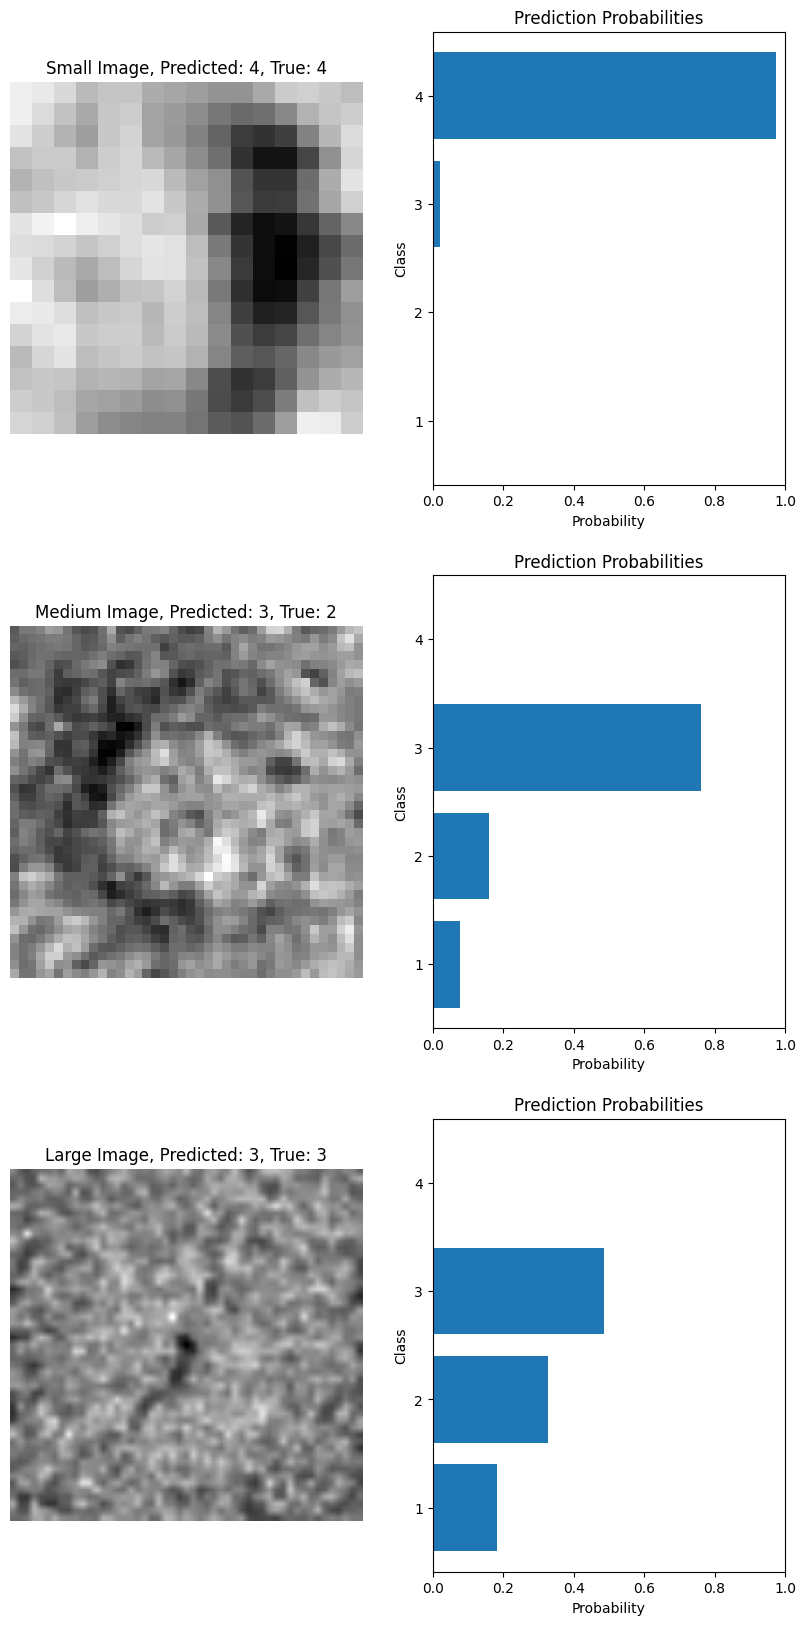

In [ ]:
'''
Example images
'''
fig, ax = plt.subplots(3,2,figsize=(10,20))
#example sm im
ex_sm_img, ex_lab = next(iter(sm_test_dataloader))
flat_preds = [lab.item() for labs in preds_model_sm for lab in labs]
ax[0][0].imshow(ex_sm_img[1].squeeze(), cmap='gray')
ax[0][0].set_title(f"Small Image, Predicted: {flat_preds[1]+1}, True: {ex_lab[1].item()}") #need to add 1 bc pred idxs restart at 0
ax[0][0].axis('off')

#get prbs for input
img_in = ex_sm_img[1].to(device).unsqueeze(0)
logits = model_sm(img_in)
#softmax for prbs
probs = F.softmax(logits, dim=1)
probs_np = probs.detach().cpu().numpy().squeeze()
ax[0][1].barh(np.arange(4)+1,probs_np)
ax[0][1].set_title('Prediction Probabilities')
ax[0][1].set_xlabel('Probability')
ax[0][1].set_yticks([1,2,3,4])
ax[0][1].set_ylabel('Class')
ax[0][1].set_xlim([0,1])


#example med im
ex_med_img, ex_lab = next(iter(med_test_dataloader))
flat_preds = [lab.item() for labs in preds_model_med for lab in labs]
ax[1][0].imshow(ex_med_img[1].squeeze(), cmap='gray')
ax[1][0].set_title(f"Medium Image, Predicted: {flat_preds[1]+1}, True: {ex_lab[1].item()}") #need to add 1 bc pred idxs restart at 0
ax[1][0].axis('off')

#get prbs for input
img_in = ex_med_img[1].to(device).unsqueeze(0)
logits = model_med(img_in)
#softmax for prbs
probs = F.softmax(logits, dim=1)
probs_np = probs.detach().cpu().numpy().squeeze()
ax[1][1].barh(np.arange(4)+1,probs_np)
ax[1][1].set_title('Prediction Probabilities')
ax[1][1].set_xlabel('Probability')
ax[1][1].set_yticks([1,2,3,4])
ax[1][1].set_ylabel('Class')
ax[1][1].set_xlim([0,1])

#example lg im
ex_lg_img, ex_lab = next(iter(lg_test_dataloader))
flat_preds = [lab.item() for labs in preds_model_lg for lab in labs]
ax[2][0].imshow(ex_lg_img[1].squeeze(), cmap='gray')
ax[2][0].set_title(f"Large Image, Predicted: {flat_preds[1]+1}, True: {ex_lab[1].item()}") #need to add 1 bc pred idxs restart at 0
ax[2][0].axis('off')

#get prbs for input
img_in = ex_lg_img[1].to(device).unsqueeze(0)
logits = model_lg(img_in)
#softmax for prbs
probs = F.softmax(logits, dim=1)
probs_np = probs.detach().cpu().numpy().squeeze()
ax[2][1].barh(np.arange(4)+1,probs_np)
ax[2][1].set_title('Prediction Probabilities')
ax[2][1].set_xlabel('Probability')
ax[2][1].set_yticks([1,2,3,4])
ax[2][1].set_ylabel('Class')
ax[2][1].set_xlim([0,1])


In [ ]:
def plot_results_by_bin(y_sm_test, preds_model_sm, y_med_test, preds_model_med, y_lg_test, preds_model_lg):
  #Plotting func to see distributions of labels in testing dataset, predicted labels, and confusion matrix
  #Note that the conf matrix idx gets reset (e.g. if only 3 classes are represented in the data, then the matrix only has idxs 0,1,2--I cannot fix this and I have tried for a long time!!)
  fig, ax = plt.subplots(3,3, figsize = (30,15))


  #small bin
  #plot hist of true labs in testing
  n, bins, patches = ax[0,0].hist(y_sm_test, bins = [0,1,2,3,4,5], density = True)
  ax[0,0].bar_label(patches)
  ax[0,0].set_title("Small Bin Test True Label Density Distribution")
  ax[0,0].set_xlabel("Labels")
  ax[0,0].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
  ax[0,0].set_xlim(1,5)
  ax[0,0].set_ylabel("Frequency")

  #plot hist of predicted labs
  y_preds_sm = [lab.item()
      for labs in preds_model_sm
      for lab in labs]
  n, bins, patches = ax[1,0].hist(np.asarray(y_preds_sm)+1,  bins = [0,1,2,3,4,5], density = True)
  ax[1,0].bar_label(patches)
  ax[1,0].set_title("Small Bin Test Predicted Label Density Distribution")
  ax[1,0].set_xlabel("Labels")
  ax[1,0].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
  ax[1,0].set_xlim(1,5)
  ax[1,0].set_ylabel("Frequency")




  #plot conf mat
  y_labs_cm_sm = [lab.item()
      for labs in labs_model_sm
      for lab in labs]
  cm_sm = confusion_matrix(np.asarray(y_labs_cm_sm)+1, np.asarray(y_preds_sm)+1)
  sns.heatmap(cm_sm, annot=True, fmt='d', ax = ax[2,0])
  ax[2,0].set_title("Small Bin Confusion Matrix")
  ax[2,0].set_xlabel("Predicted")
  ax[2,0].set_ylabel("True")

  #med bin
  #plot hist of true labs in testing
  n, bins, patches = ax[0,1].hist(y_med_test, bins = [0,1,2,3,4,5], density = True)
  ax[0,1].bar_label(patches)
  ax[0,1].set_title("Med Bin Test True Label Density Distribution")
  ax[0,1].set_xlabel("Labels")
  ax[0,1].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
  ax[0,1].set_xlim(1,5)
  ax[0,1].set_ylabel("Frequency")


  #plot hist of predicted labs
  y_preds_med = [lab.item()
      for labs in preds_model_med
      for lab in labs]
  n, bins, patches = ax[1,1].hist(np.asarray(y_preds_med)+1,  bins = [0,1,2,3,4,5], density = True)
  ax[1,1].bar_label(patches)
  ax[1,1].set_title("Medium Bin Test Predicted Label Density Distribution")
  ax[1,1].set_xlabel("Labels")
  ax[1,1].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
  ax[1,1].set_xlim(1,5)
  ax[1,1].set_ylabel("Frequency")

  #plot conf mat
  y_labs_cm_med = [lab.item()
      for labs in labs_model_med
      for lab in labs]
  cm_med = confusion_matrix(np.asarray(y_labs_cm_med)+1, np.asarray(y_preds_med)+1)
  sns.heatmap(cm_med, annot=True, fmt='d', ax = ax[2,1])
  ax[2,1].set_title("Medium Bin Confusion Matrix")
  ax[2,1].set_xlabel("Predicted")
  ax[2,1].set_ylabel("True")



  #large bin
  #plot hist of true labs in testing
  n, bins, patches = ax[0,2].hist(y_lg_test,  bins = [0,1,2,3,4,5], density = True)
  ax[0,2].bar_label(patches)
  ax[0,2].set_title("Large Bin Test True Label Density Distribution")
  ax[0,2].set_xlabel("Labels")
  ax[0,2].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
  ax[0,2].set_xlim(1,5)
  ax[0,2].set_ylabel("Frequency")


  #plot hist of predicted labs
  y_preds_lg = [lab.item()
      for labs in preds_model_lg
      for lab in labs]
  n, bins, patches = ax[1,2].hist(np.asarray(y_preds_lg)+1,  bins = [0,1,2,3,4,5], density = True)
  ax[1,2].bar_label(patches)
  ax[1,2].set_title("Large Bin Test Predicted Label Density Distribution")
  ax[1,2].set_xlabel("Labels")
  ax[1,2].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
  ax[1,2].set_xlim(1,5)
  ax[1,2].set_ylabel("Frequency")

  #plot conf mat
  y_labs_cm_lg = [lab.item()
      for labs in labs_model_lg
      for lab in labs]
  cm_lg = confusion_matrix(np.asarray(y_labs_cm_lg)+1, np.asarray(y_preds_lg)+1)
  sns.heatmap(cm_lg, annot=True, fmt='d', ax = ax[2,2])
  ax[2,2].set_title("Large Bin Confusion Matrix")
  ax[2,2].set_xlabel("Predicted")
  ax[2,2].set_ylabel("True")


  plt.tight_layout
  plt.show()

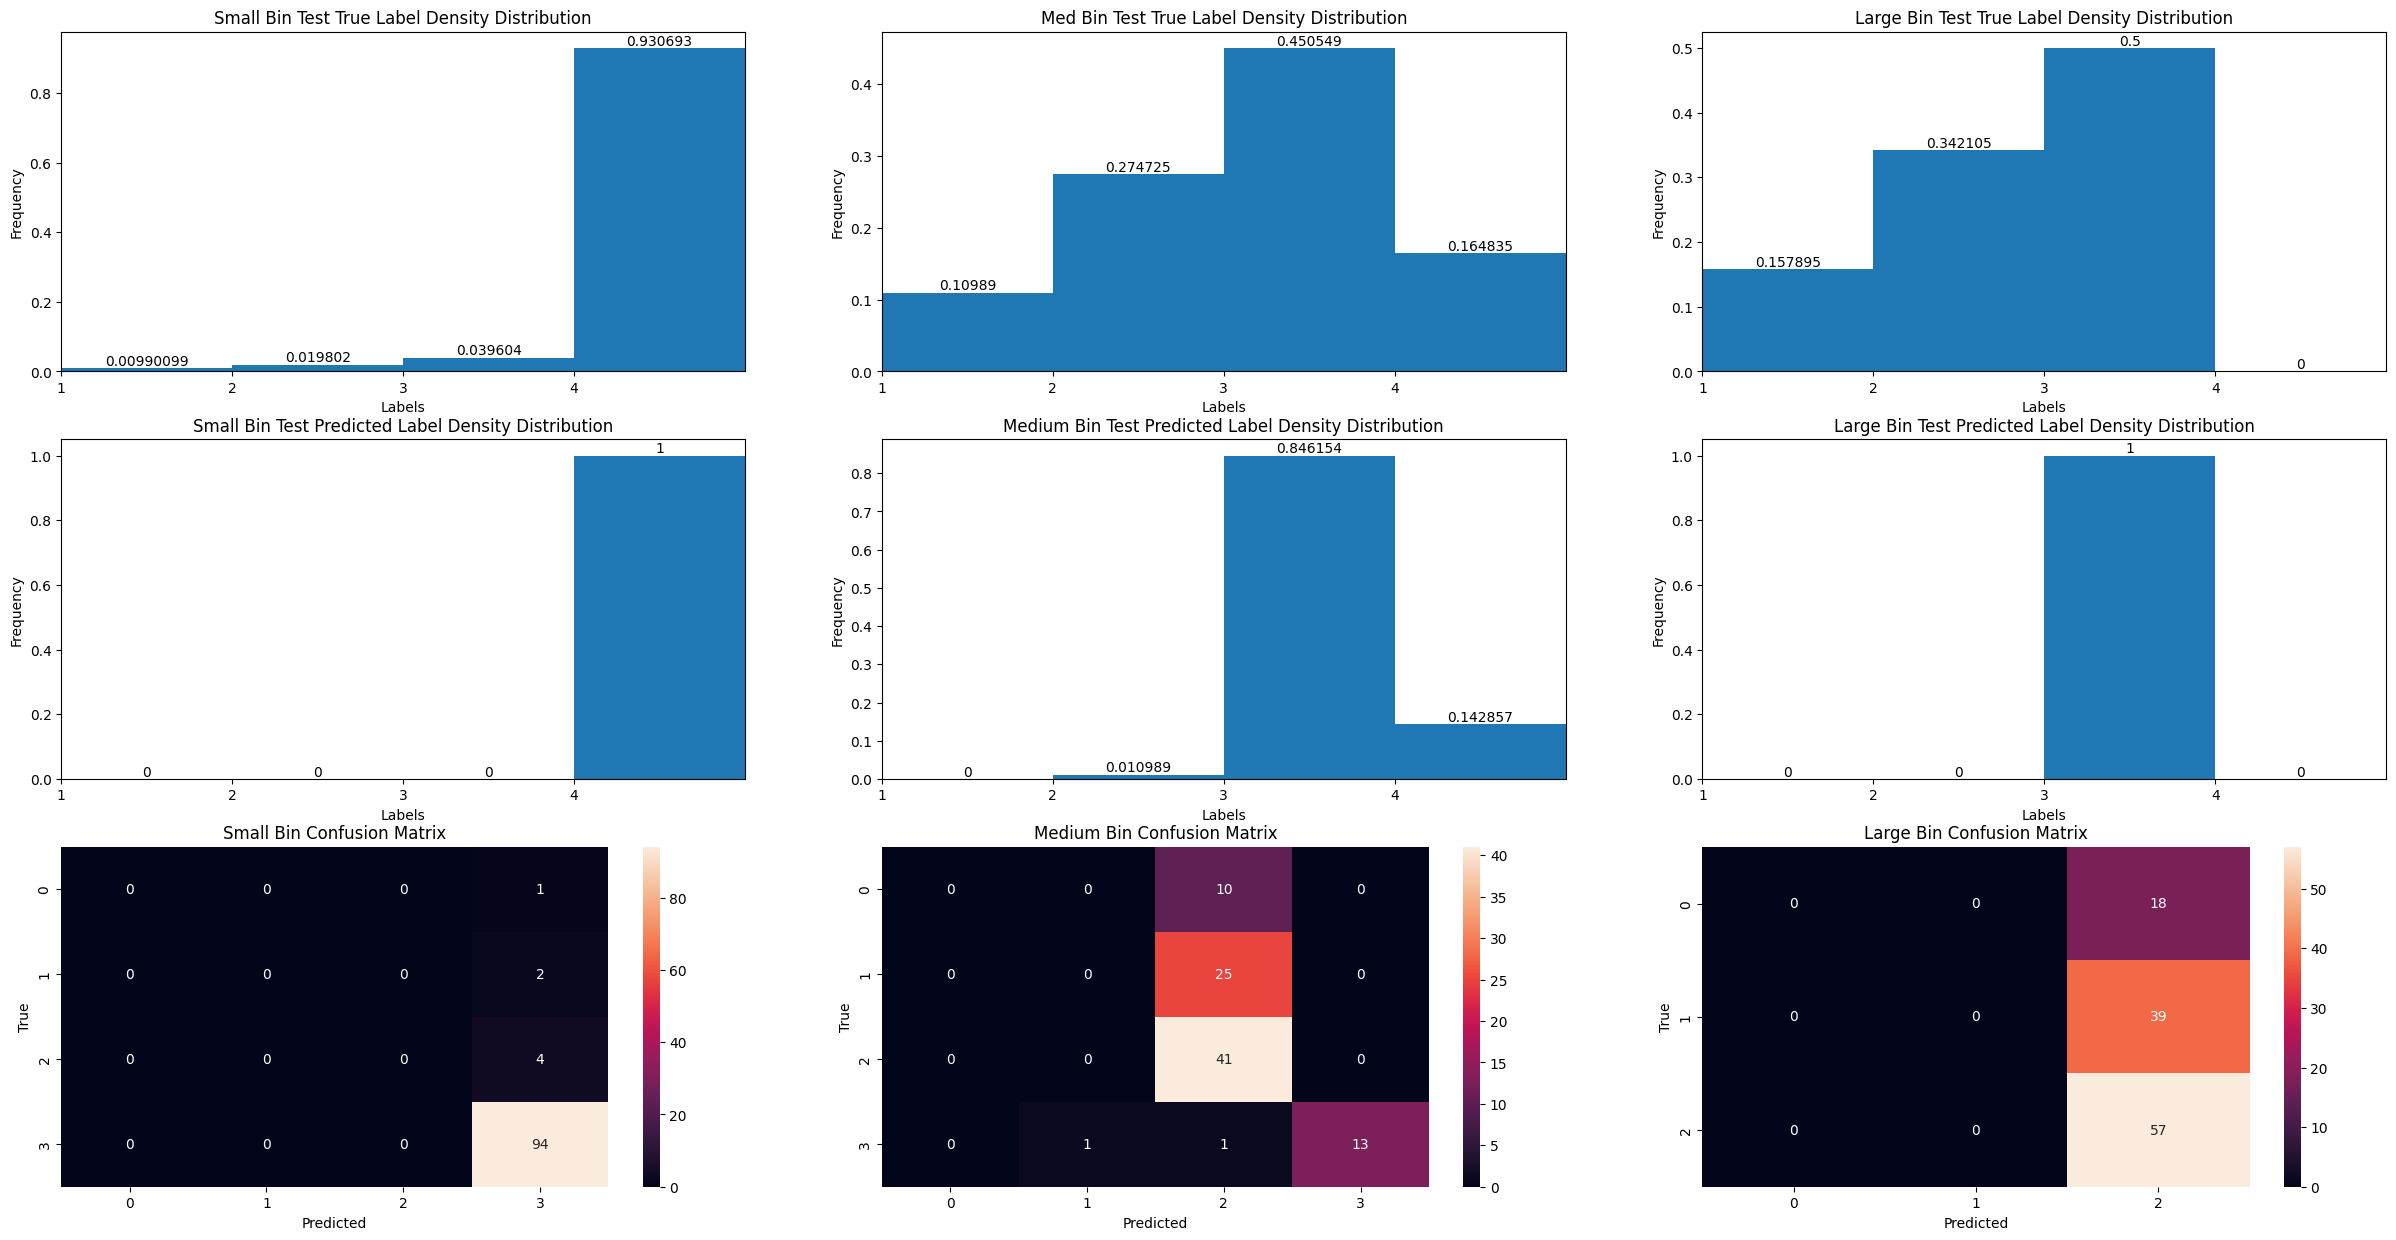

In [ ]:

'''
CNN potential issue and our attempt to address the issue:
Is our model actually learning the statistics of the images or simply guessing the most common class?
Since our data classes are quite imbalanced, we introduced inverse class frequency weights into the loss function.
'''
plot_results_by_bin(y_sm_test, preds_model_sm, y_med_test, preds_model_med, y_lg_test, preds_model_lg)

Training and testing SMALL image samples (16 x 16)


	Accuracy of model on train epoch # 1: 0.9625
	Current loss of train epoch # 1: 1.2936488437652587

	Accuracy of model on train epoch # 2: 0.9625
	Current loss of train epoch # 2: 1.227817540168762

	Accuracy of model on train epoch # 3: 0.9625
	Current loss of train epoch # 3: 1.1120810317993164

	Accuracy of model on train epoch # 4: 0.9625
	Current loss of train epoch # 4: 1.1096896743774414

	Accuracy of model on train epoch # 5: 0.9575
	Current loss of train epoch # 5: 1.2255401873588563

	Accuracy of model on train epoch # 6: 0.9625
	Current loss of train epoch # 6: 1.1721947574615479

	Accuracy of model on train epoch # 7: 0.9625
	Current loss of train epoch # 7: 1.0585361409187317

	Accuracy of model on train epoch # 8: 0.9625
	Current loss of train epoch # 8: 1.0207259500026702

	Accuracy of model on train epoch # 9: 0.9625
	Current loss of train epoch # 9: 0.9977992630004883

	Accuracy of model on train epoch # 10: 0.9625
	

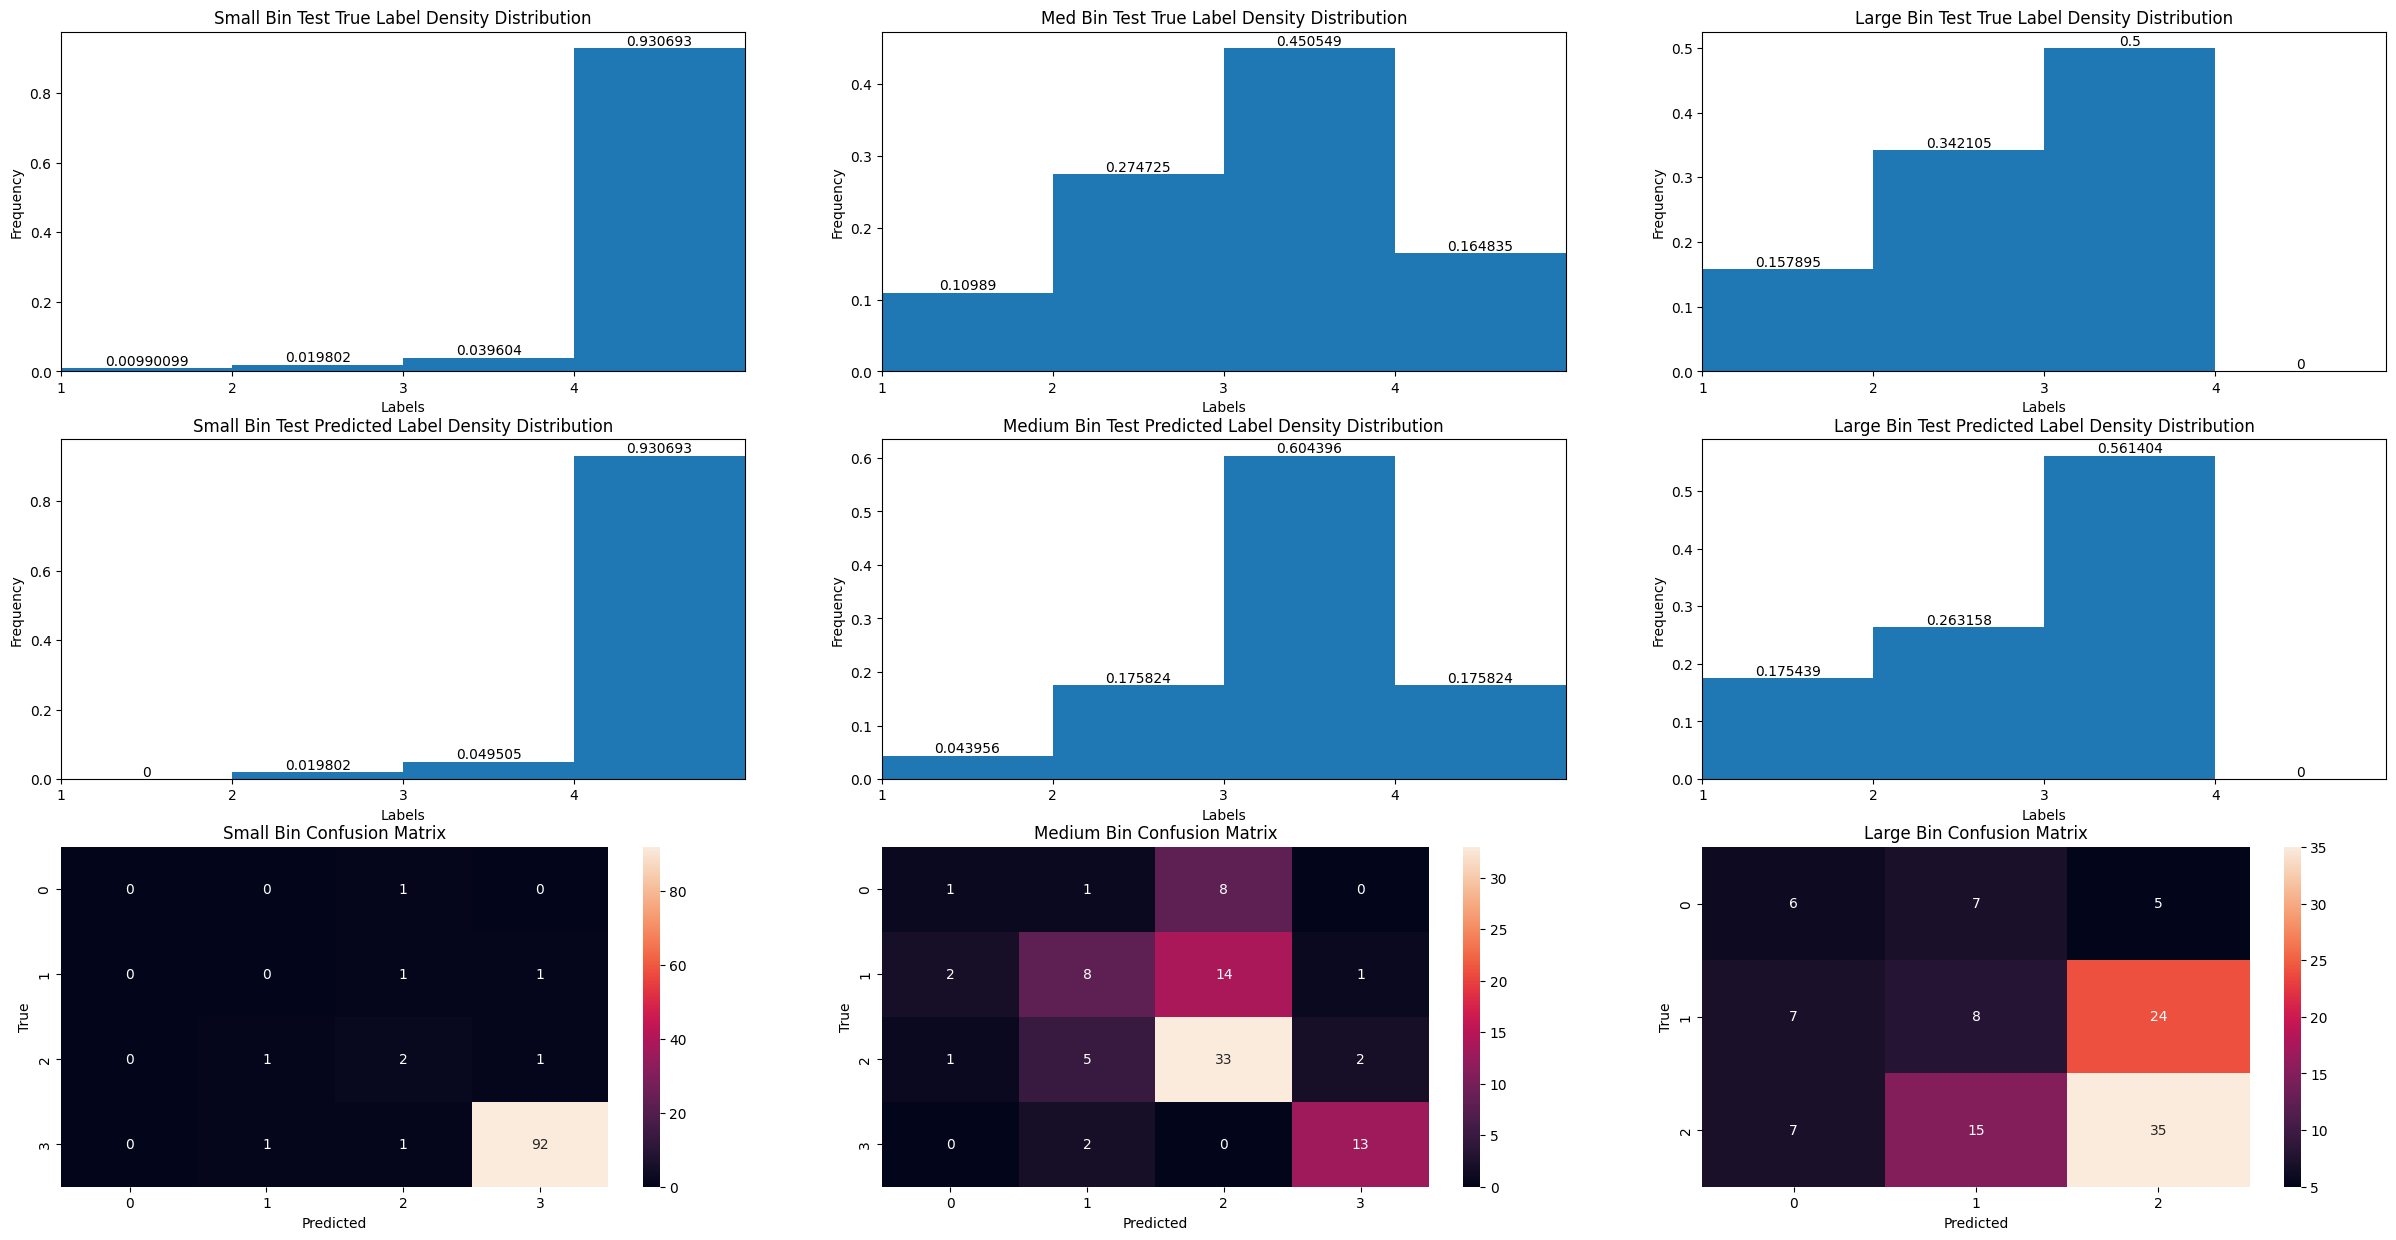

In [ ]:
'''
Let's introduce weights inverse to class frequency to attempt to prevent model from simply guessing the most common class
'''
#train new models with inverse freq wts
def inv_freq_wts(y_train_labs, n_classes):
  #takes in list of training labels to introduce inverse freq weights to prevent model from fitting to distribution of classes
  new_labs = [l - 1 for l in y_train_labs]
  counts = Counter(new_labs)
  #get total counts per class
  counts_per_class = torch.tensor([counts.get(i, 0) for i in range(n_classes)], dtype=torch.float32)
  class_weights = 1.0 / (counts_per_class + 1e-6) #add small number in case divide by 0
  class_weights = class_weights / class_weights.sum() * n_classes

  return class_weights

#set some hyperparams
n_classes = 4
n_epochs = 30
learn_rt = 1e-3


#small bin
print(f'Training and testing SMALL image samples ({sm_bin_upper} x {sm_bin_upper})\n')
model_sm = NeuralNet(img_dim=sm_bin_upper, num_classes=n_classes)
# class wts for the small bin training labels using inverse freq
class_weights_sm = inv_freq_wts(y_sm_train, n_classes)

model_sm = train_model(model_sm, sm_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_sm)
preds_model_sm, labs_model_sm = test_model(model_sm, sm_test_dataloader)


#med bin
print(f'Training and testing MEDIUM image samples ({med_bin_upper} x {med_bin_upper})\n')
model_med = NeuralNet(img_dim=med_bin_upper, num_classes=n_classes)
# class wts for the small bin training labels using inverse freq
class_weights_med = inv_freq_wts(y_med_train, n_classes)

model_med = train_model(model_med, med_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_med)
preds_model_med, labs_model_med = test_model(model_med, med_test_dataloader)


#large bin
print(f'Training and testing LARGE image samples ({lg_bin_upper} x {lg_bin_upper})\n')
model_lg = NeuralNet(img_dim=lg_bin_upper, num_classes=n_classes)
# class wts for the small bin training labels using inverse freq
class_weights_lg = inv_freq_wts(y_lg_train, n_classes)

model_lg = train_model(model_lg, lg_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_lg)
preds_model_lg, labs_model_lg = test_model(model_lg, lg_test_dataloader)


#see distributions of class labels
plot_results_by_bin(y_sm_test, preds_model_sm, y_med_test, preds_model_med, y_lg_test, preds_model_lg)

Training and testing SMALL image samples (16 x 16)


	Accuracy of model on train epoch # 1: 0.1025
	Current loss of train epoch # 1: 1.3719911575317383

	Accuracy of model on train epoch # 2: 0.915
	Current loss of train epoch # 2: 1.291068525314331

	Accuracy of model on train epoch # 3: 0.9625
	Current loss of train epoch # 3: 1.1652123308181763

	Accuracy of model on train epoch # 4: 0.9625
	Current loss of train epoch # 4: 1.210022530555725

	Accuracy of model on train epoch # 5: 0.9625
	Current loss of train epoch # 5: 1.1448821067810058

	Accuracy of model on train epoch # 6: 0.9425
	Current loss of train epoch # 6: 1.0650941967964171

	Accuracy of model on train epoch # 7: 0.9375
	Current loss of train epoch # 7: 1.0744011306762695

	Accuracy of model on train epoch # 8: 0.9575
	Current loss of train epoch # 8: 1.153999273777008

	Accuracy of model on train epoch # 9: 0.9525
	Current loss of train epoch # 9: 1.1402852392196656

	Accuracy of model on train epoch # 10: 0.9525
	Cur

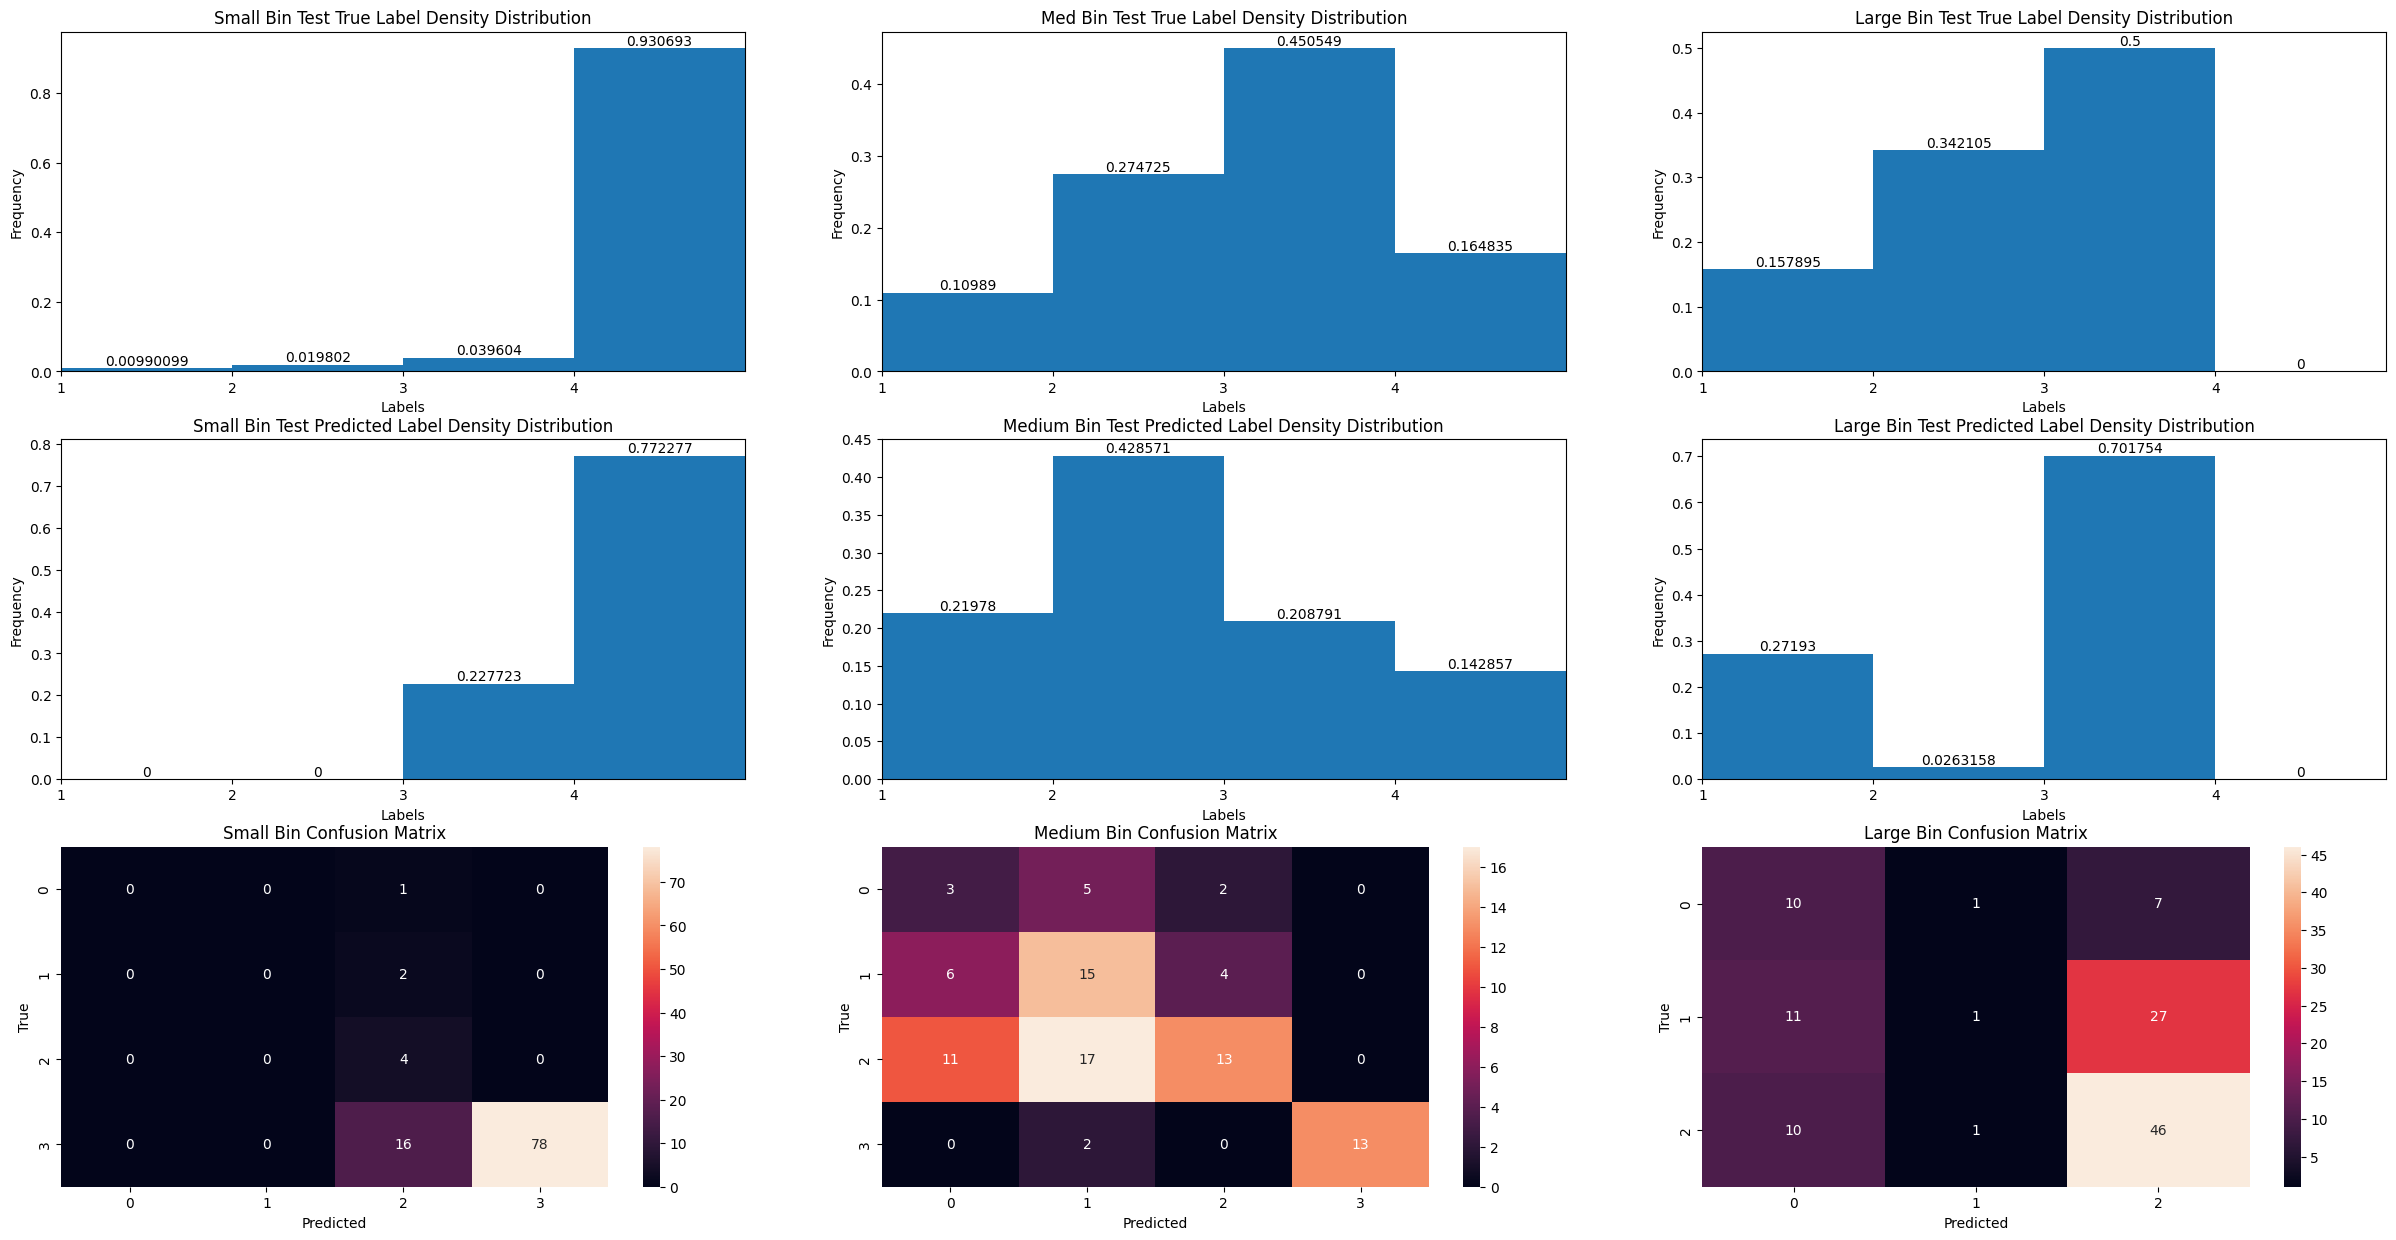

In [ ]:
'''
Let's try adding another layer
'''
#try adding another layer
#set some hyperparams
n_classes = 4
n_epochs = 30
learn_rt = 1e-3

#small bin
print(f'Training and testing SMALL image samples ({sm_bin_upper} x {sm_bin_upper})\n')
model_sm = NeuralNet(img_dim=sm_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_sm = inv_freq_wts(y_sm_train, n_classes)

model_sm = train_model(model_sm, sm_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_sm)
preds_model_sm, labs_model_sm = test_model(model_sm, sm_test_dataloader)


#med bin
print(f'Training and testing MEDIUM image samples ({med_bin_upper} x {med_bin_upper})\n')
model_med = NeuralNet(img_dim=med_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_med = inv_freq_wts(y_med_train, n_classes)

model_med = train_model(model_med, med_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_med)
preds_model_med, labs_model_med = test_model(model_med, med_test_dataloader)


#large bin
print(f'Training and testing LARGE image samples ({lg_bin_upper} x {lg_bin_upper})\n')
model_lg = NeuralNet(img_dim=lg_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_lg = inv_freq_wts(y_lg_train, n_classes)

model_lg = train_model(model_lg, lg_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_lg)
preds_model_lg, labs_model_lg = test_model(model_lg, lg_test_dataloader)


#see distributions of class labels
plot_results_by_bin(y_sm_test, preds_model_sm, y_med_test, preds_model_med, y_lg_test, preds_model_lg)



Training and testing SMALL image samples (16 x 16)


	Accuracy of model on train epoch # 1: 0.6825
	Current loss of train epoch # 1: 1.41286874294281

	Accuracy of model on train epoch # 2: 0.9625
	Current loss of train epoch # 2: 1.2130320620536805

	Accuracy of model on train epoch # 3: 0.9625
	Current loss of train epoch # 3: 1.1933222007751465

	Accuracy of model on train epoch # 4: 0.8275
	Current loss of train epoch # 4: 1.5657084965705872

	Accuracy of model on train epoch # 5: 0.75
	Current loss of train epoch # 5: 1.2682953929901124

	Accuracy of model on train epoch # 6: 0.8025
	Current loss of train epoch # 6: 1.3065786647796631

	Accuracy of model on train epoch # 7: 0.9475
	Current loss of train epoch # 7: 1.2338098168373108

	Accuracy of model on train epoch # 8: 0.8925
	Current loss of train epoch # 8: 1.2591000175476075

	Accuracy of model on train epoch # 9: 0.9625
	Current loss of train epoch # 9: 1.1220806074142455

	Accuracy of model on train epoch # 10: 0.9625
	Cur

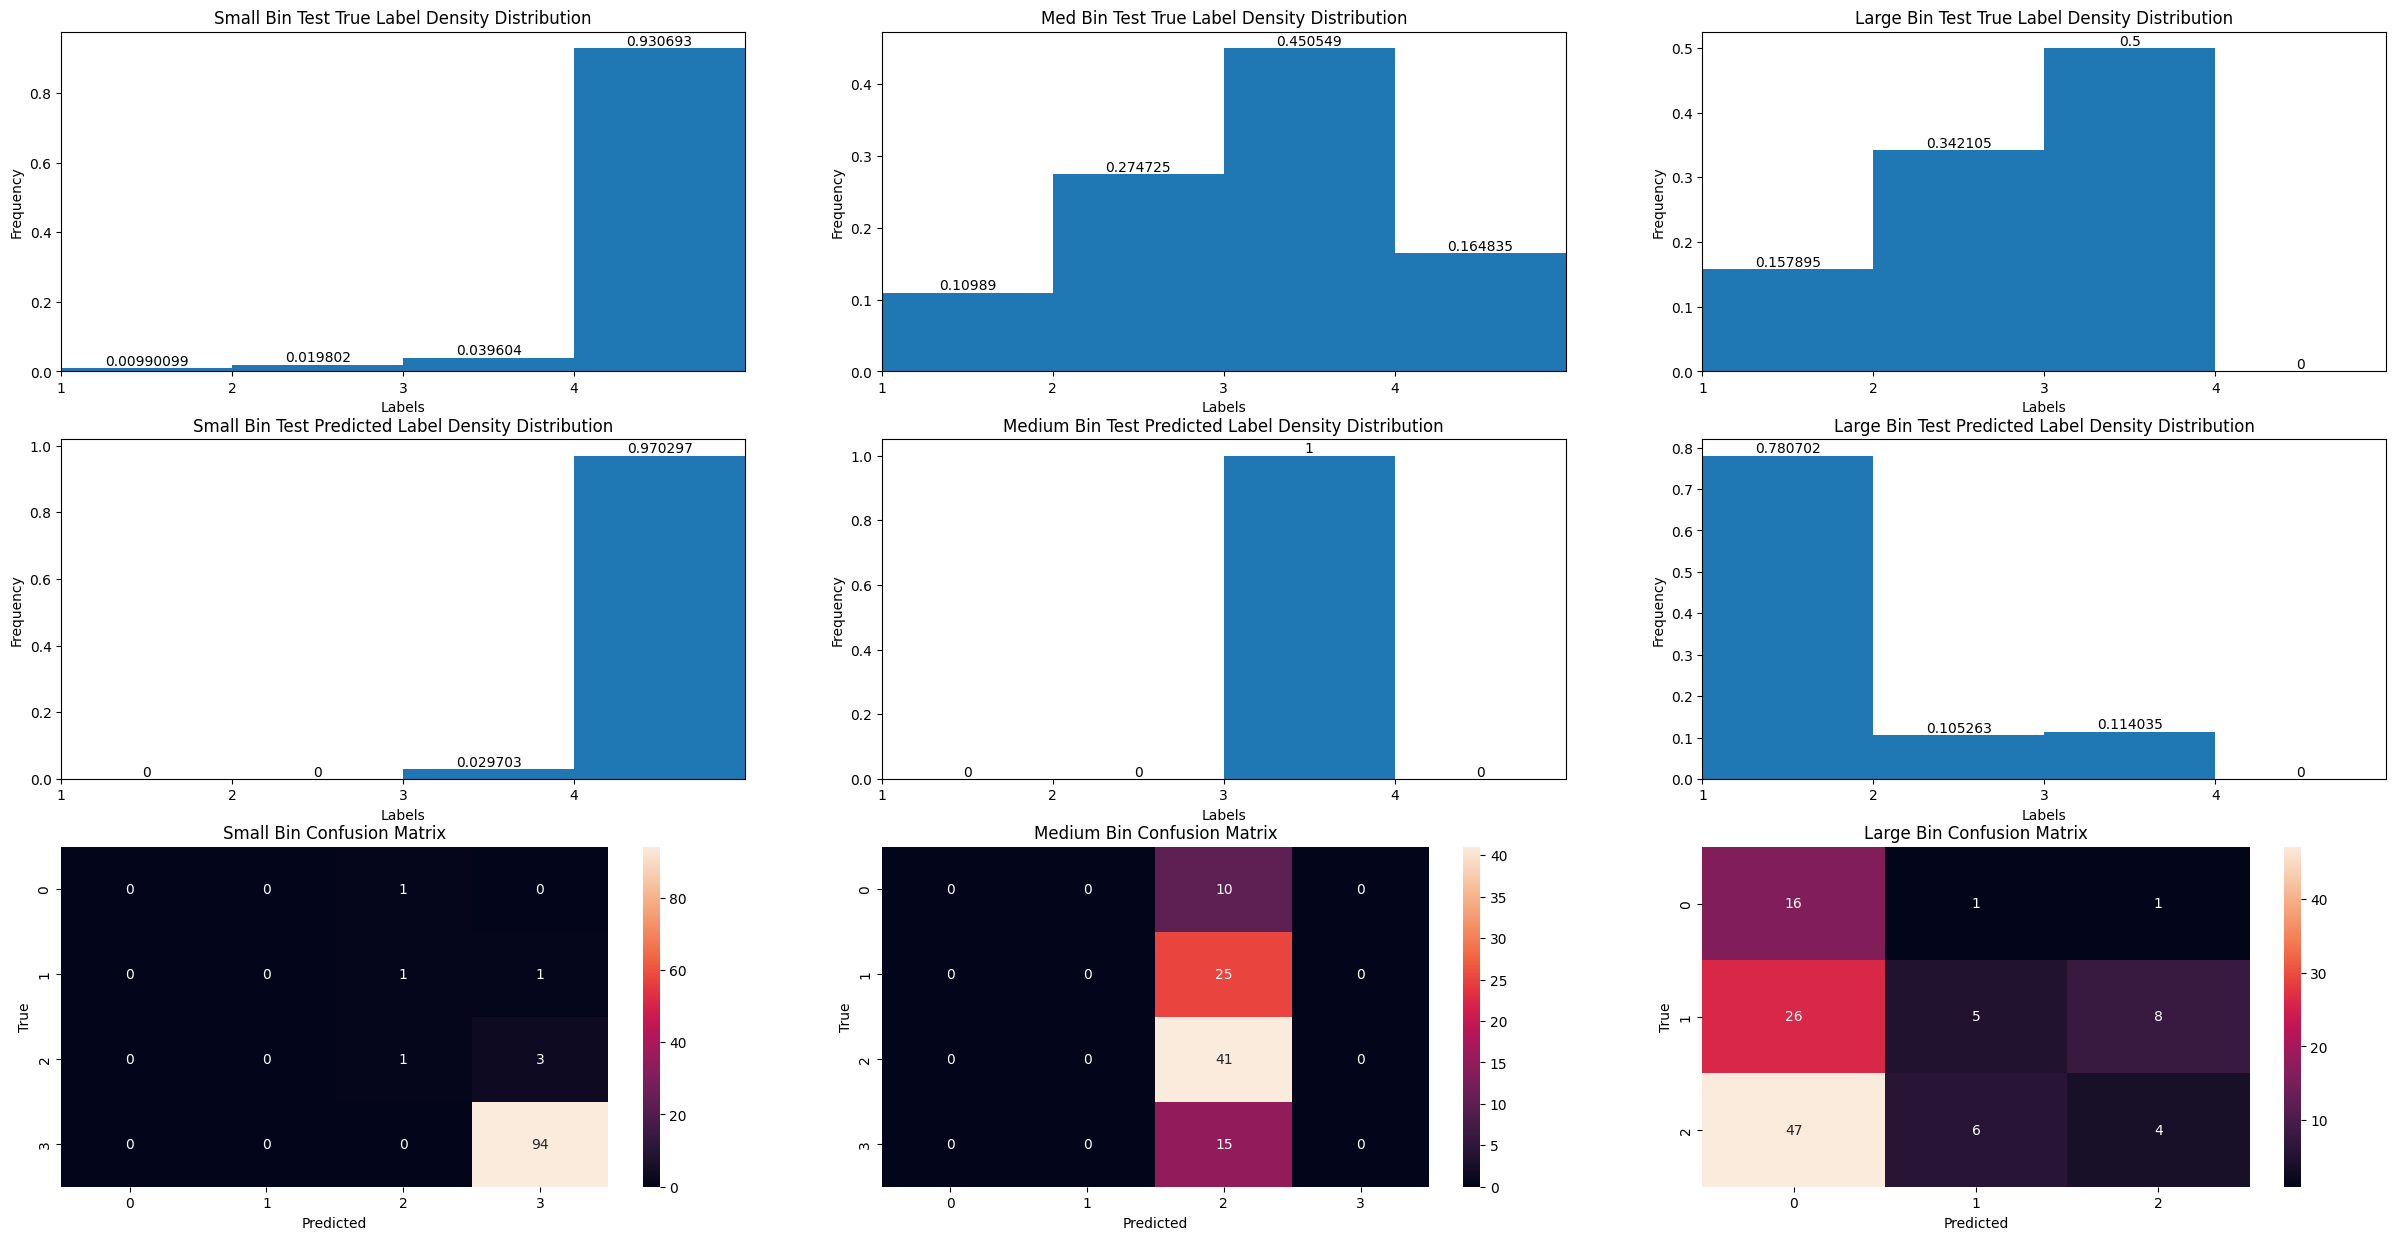

In [ ]:
'''
Unclear if that helped, let's adjust lr 1 order of magnitude up (I already tried moving it down and the model performed much worse.)
'''

#set some hyperparams
n_classes = 4
n_epochs = 30
learn_rt = 1e-2

#small bin
print(f'Training and testing SMALL image samples ({sm_bin_upper} x {sm_bin_upper})\n')
model_sm = NeuralNet(img_dim=sm_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_sm = inv_freq_wts(y_sm_train, n_classes)

model_sm = train_model(model_sm, sm_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_sm)
preds_model_sm, labs_model_sm = test_model(model_sm, sm_test_dataloader)


#med bin
print(f'Training and testing MEDIUM image samples ({med_bin_upper} x {med_bin_upper})\n')
model_med = NeuralNet(img_dim=med_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_med = inv_freq_wts(y_med_train, n_classes)

model_med = train_model(model_med, med_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_med)
preds_model_med, labs_model_med = test_model(model_med, med_test_dataloader)


#large bin
print(f'Training and testing LARGE image samples ({lg_bin_upper} x {lg_bin_upper})\n')
model_lg = NeuralNet(img_dim=lg_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_lg = inv_freq_wts(y_lg_train, n_classes)

model_lg = train_model(model_lg, lg_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_lg)
preds_model_lg, labs_model_lg = test_model(model_lg, lg_test_dataloader)


#see distributions of class labels
plot_results_by_bin(y_sm_test, preds_model_sm, y_med_test, preds_model_med, y_lg_test, preds_model_lg)

Training and testing SMALL image samples (16 x 16)


	Accuracy of model on train epoch # 1: 0.9425
	Current loss of train epoch # 1: 1.3886895513534545

	Accuracy of model on train epoch # 2: 0.9525
	Current loss of train epoch # 2: 1.3136146640777588

	Accuracy of model on train epoch # 3: 0.9525
	Current loss of train epoch # 3: 1.315955672264099

	Accuracy of model on train epoch # 4: 0.9525
	Current loss of train epoch # 4: 1.1680109453201295

	Accuracy of model on train epoch # 5: 0.96
	Current loss of train epoch # 5: 1.226796178817749

	Accuracy of model on train epoch # 6: 0.9375
	Current loss of train epoch # 6: 1.1779579854011535

	Accuracy of model on train epoch # 7: 0.955
	Current loss of train epoch # 7: 1.158480830192566

	Accuracy of model on train epoch # 8: 0.955
	Current loss of train epoch # 8: 1.3105765438079835

	Accuracy of model on train epoch # 9: 0.95
	Current loss of train epoch # 9: 1.1822319316864014

	Accuracy of model on train epoch # 10: 0.925
	Current l

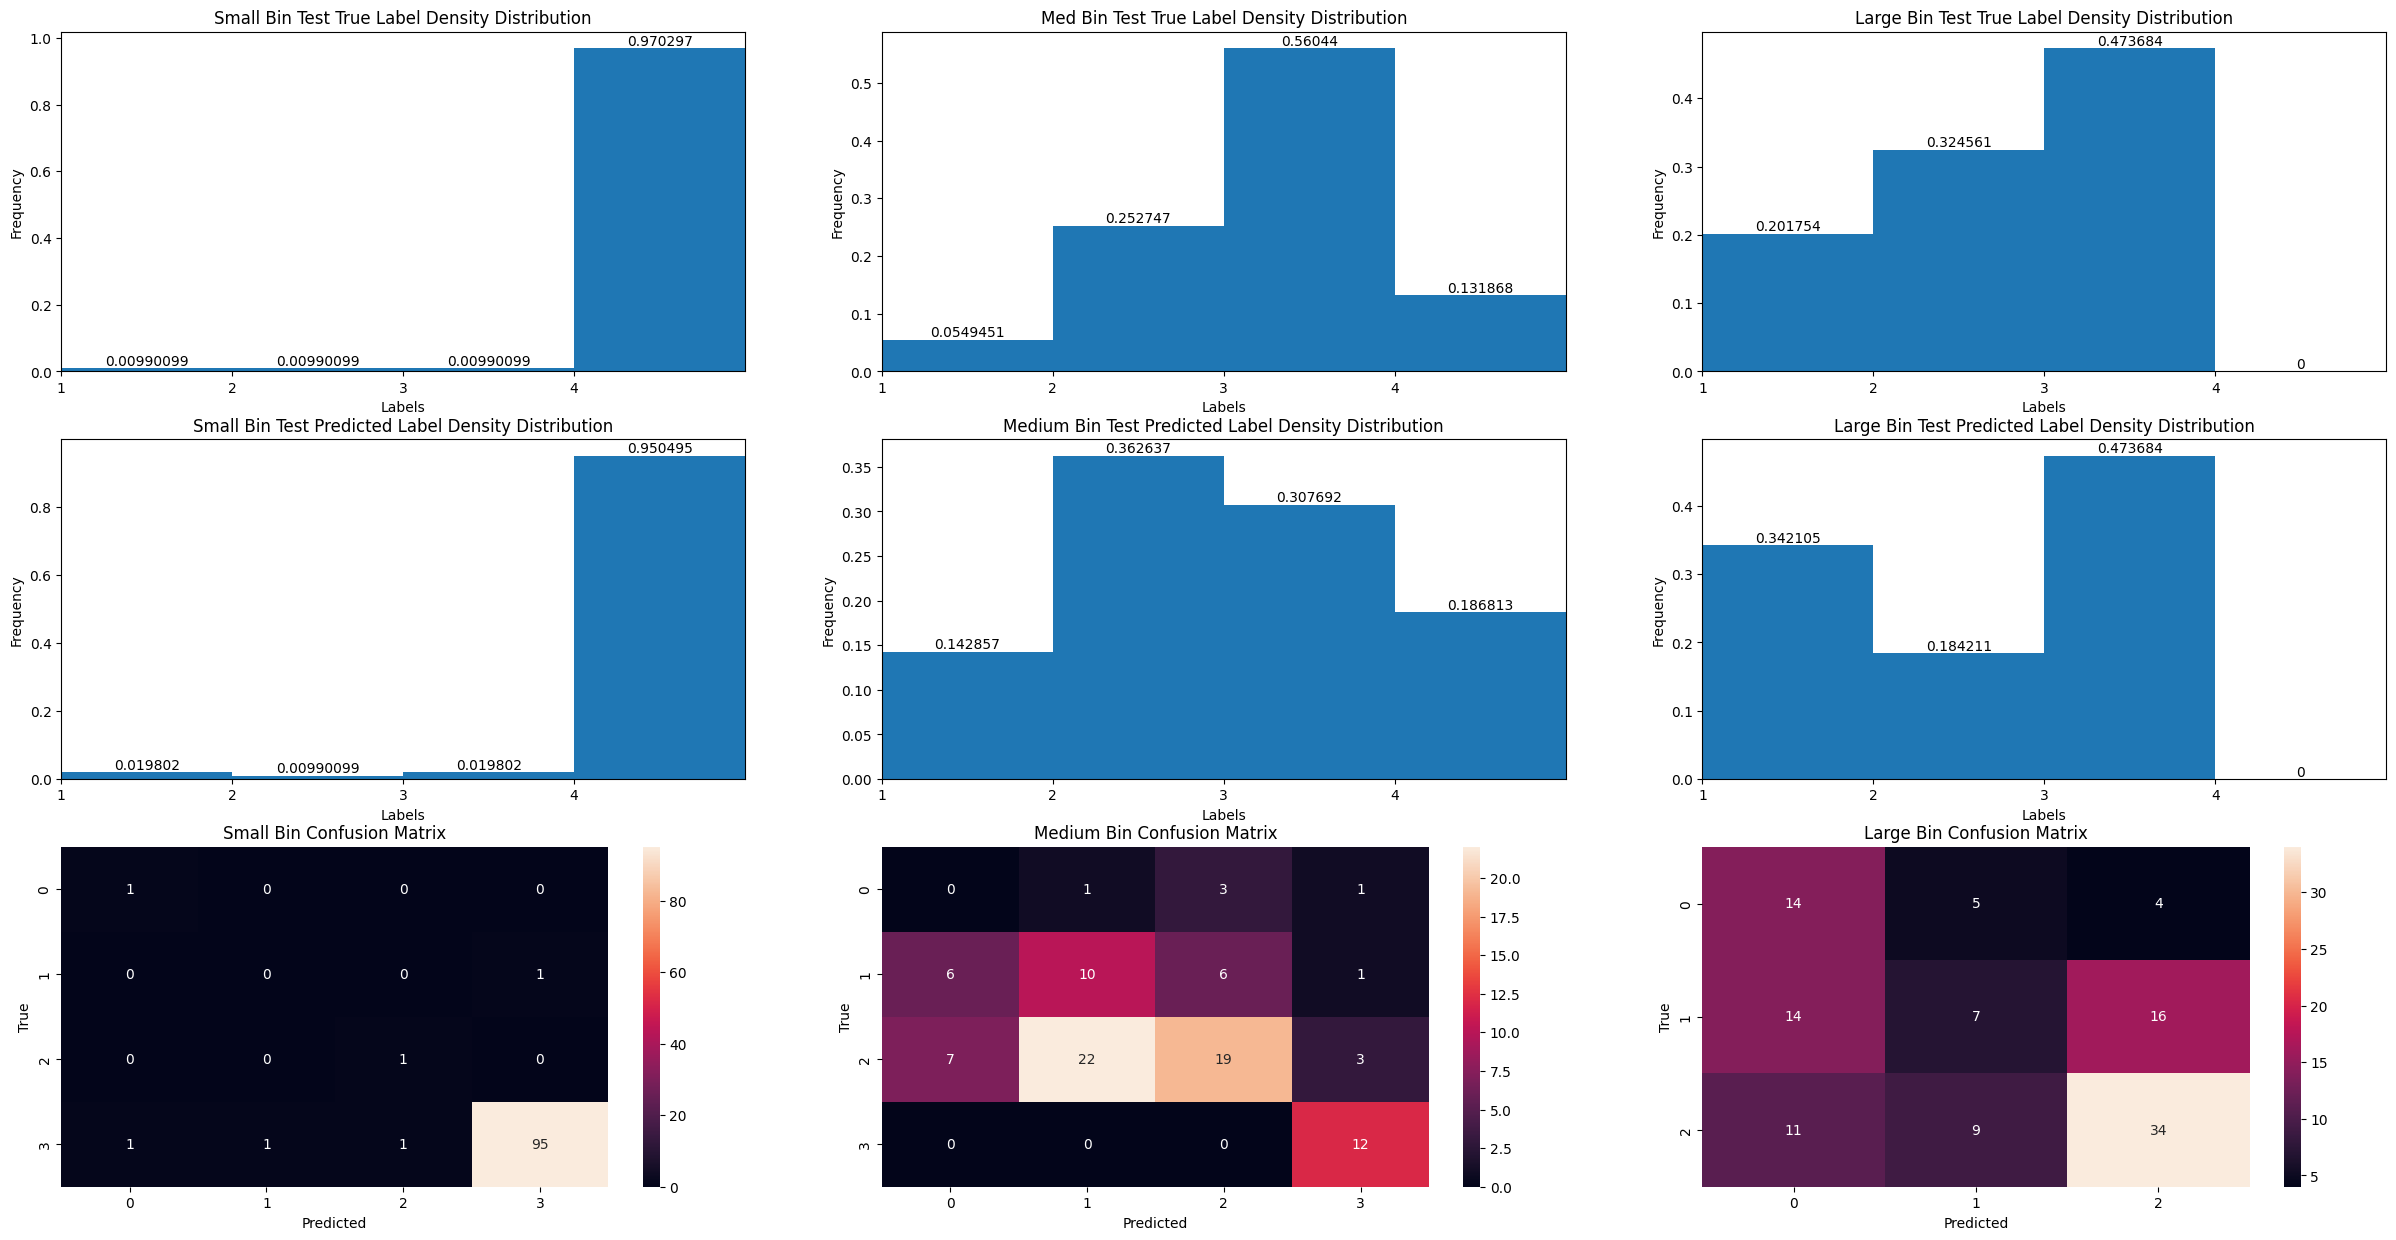

In [ ]:
'''
Well, adjust lr didn't help at all. Let's try changing batch size from 32 to 16 (I already tried changing from 32 to 64 and it performed much more poorly)
'''

#set some hyperparams
n_classes = 4
n_epochs = 30
learn_rt = 1e-3
batch_sz = 64

#split into 3 datasets by size of img using new batch sz
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(sm_bin, sm_bin_labels, test_size=0.2)
sm_train_dataset = GrayVolcanoes(X_sm_train, y_sm_train, (sm_bin_upper, sm_bin_upper))
sm_test_dataset = GrayVolcanoes(X_sm_test, y_sm_test, (sm_bin_upper, sm_bin_upper))
sm_train_dataloader = DataLoader(sm_train_dataset, batch_size=batch_sz, shuffle=True)
sm_test_dataloader = DataLoader(sm_test_dataset, batch_size=batch_sz, shuffle=False)

X_med_train, X_med_test, y_med_train, y_med_test = train_test_split(med_bin, med_bin_labels, test_size=0.2)
med_train_dataset = GrayVolcanoes(X_med_train, y_med_train, (med_bin_upper, med_bin_upper))
med_test_dataset = GrayVolcanoes(X_med_test, y_med_test, (med_bin_upper, med_bin_upper))
med_train_dataloader = DataLoader(med_train_dataset, batch_size=batch_sz, shuffle=True)
med_test_dataloader = DataLoader(med_test_dataset, batch_size=batch_sz, shuffle=False)

X_lg_train, X_lg_test, y_lg_train, y_lg_test = train_test_split(lg_bin, lg_bin_labels, test_size=0.2)
lg_train_dataset = GrayVolcanoes(X_lg_train, y_lg_train, (lg_bin_upper, lg_bin_upper))
lg_test_dataset = GrayVolcanoes(X_lg_test, y_lg_test, (lg_bin_upper, lg_bin_upper))
lg_train_dataloader = DataLoader(lg_train_dataset, batch_size=batch_sz, shuffle=True)
lg_test_dataloader = DataLoader(lg_test_dataset, batch_size=batch_sz, shuffle=False)

#small bin
print(f'Training and testing SMALL image samples ({sm_bin_upper} x {sm_bin_upper})\n')
model_sm = NeuralNet(img_dim=sm_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_sm = inv_freq_wts(y_sm_train, n_classes)

model_sm = train_model(model_sm, sm_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_sm)
preds_model_sm, labs_model_sm = test_model(model_sm, sm_test_dataloader)


#med bin
print(f'Training and testing MEDIUM image samples ({med_bin_upper} x {med_bin_upper})\n')
model_med = NeuralNet(img_dim=med_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_med = inv_freq_wts(y_med_train, n_classes)

model_med = train_model(model_med, med_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_med)
preds_model_med, labs_model_med = test_model(model_med, med_test_dataloader)


#large bin
print(f'Training and testing LARGE image samples ({lg_bin_upper} x {lg_bin_upper})\n')
model_lg = NeuralNet(img_dim=lg_bin_upper, num_classes=n_classes, addl_layer = True)
# class wts for the small bin training labels using inverse freq
class_weights_lg = inv_freq_wts(y_lg_train, n_classes)

model_lg = train_model(model_lg, lg_train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt, class_weights=class_weights_lg)
preds_model_lg, labs_model_lg = test_model(model_lg, lg_test_dataloader)


#see distributions of class labels
plot_results_by_bin(y_sm_test, preds_model_sm, y_med_test, preds_model_med, y_lg_test, preds_model_lg)


	Accuracy of model on train epoch # 1: 0.3404605263157895
	Current loss of train epoch # 1: 1.3157891819351597

	Accuracy of model on train epoch # 2: 0.3495065789473684
	Current loss of train epoch # 2: 1.2917815039032383

	Accuracy of model on train epoch # 3: 0.41694078947368424
	Current loss of train epoch # 3: 1.2518142101011778

	Accuracy of model on train epoch # 4: 0.6134868421052632
	Current loss of train epoch # 4: 0.9419977366924286

	Accuracy of model on train epoch # 5: 0.6447368421052632
	Current loss of train epoch # 5: 0.8550284410777845

	Accuracy of model on train epoch # 6: 0.6595394736842105
	Current loss of train epoch # 6: 0.7856591688959222

	Accuracy of model on train epoch # 7: 0.6702302631578947
	Current loss of train epoch # 7: 0.7612569802685788

	Accuracy of model on train epoch # 8: 0.6620065789473685
	Current loss of train epoch # 8: 0.7485041869314093

	Accuracy of model on train epoch # 9: 0.6669407894736842
	Current loss of train epoch # 9: 0.74585604

Text(33.22222222222222, 0.5, 'True')

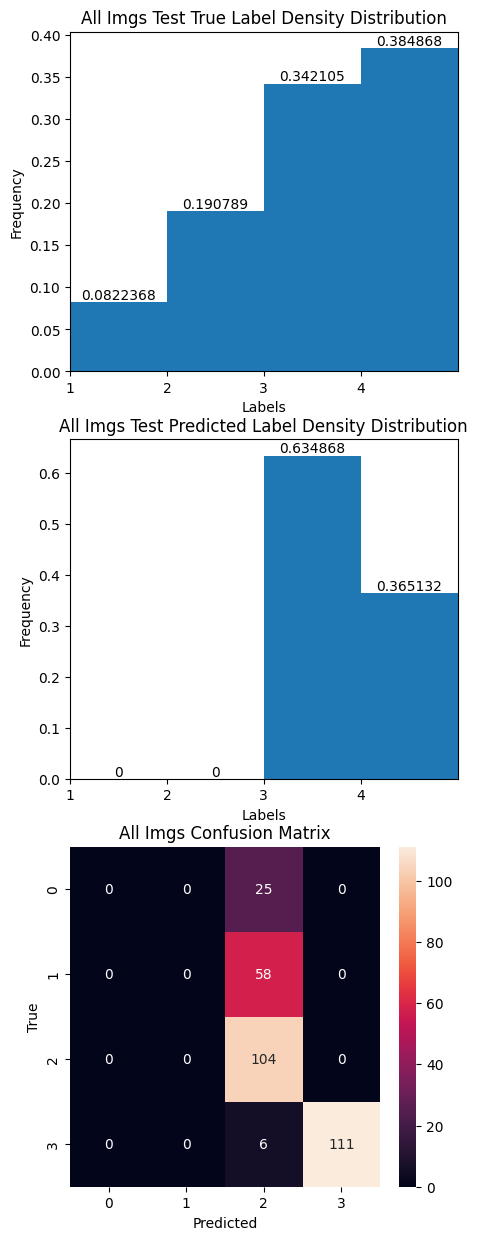

In [ ]:
'''
Ok that did not help at all and I am out of ideas to feasibly try within the project contraints. Let's try something else:
Maybe the size of the geologic structure is predictive of its volcano-ness so let's try no binning,
just resize everything to 64x64
'''
#rescale img to 64 px x 64 px
global_resize = 64
img_mats = [volcano[3] for volcano in sortedVolcanoes]
labs = [volcano[1] for volcano in sortedVolcanoes]
X_train, X_test, y_train, y_test = train_test_split(img_mats, labs, test_size=0.2)

#set up train,test split
train_dataset = GrayVolcanoes(X_train, y_train, (global_resize,global_resize))
test_dataset = GrayVolcanoes(X_test, y_test, (global_resize,global_resize))
batch_sz = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False)

#train model
model_complete = NeuralNet(img_dim=global_resize, num_classes=n_classes, addl_layer = True)
model_complete = train_model(model_complete, train_dataloader, num_epochs=n_epochs, learning_rate=learn_rt)
preds_model_complete, labs_model_complete = test_model(model_complete, test_dataloader)


#see distributions of labels
fig, ax = plt.subplots(3,1, figsize = (5,15))

#plot hist of true labs in testing
n, bins, patches = ax[0].hist(y_test, bins = [0,1,2,3,4,5], density = True)
ax[0].bar_label(patches)
ax[0].set_title("All Imgs Test True Label Density Distribution")
ax[0].set_xlabel("Labels")
ax[0].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
ax[0].set_xlim(1,5)
ax[0].set_ylabel("Frequency")


#plot hist of predicted labs
y_preds = [lab.item()
    for labs in preds_model_complete
    for lab in labs]
n, bins, patches = ax[1].hist(np.asarray(y_preds)+1, bins = [0,1,2,3,4,5], density = True)
ax[1].bar_label(patches)
ax[1].set_title("All Imgs Test Predicted Label Density Distribution")
ax[1].set_xlabel("Labels")
ax[1].set_xticks(np.asarray(range(1,5)), ['1', '2', '3', '4' ])
ax[1].set_xlim(1,5)
ax[1].set_ylabel("Frequency")

#plot conf mat
y_labs_cm = [lab.item()
    for labs in labs_model_complete
    for lab in labs]
cm = confusion_matrix(y_labs_cm, y_preds)
sns.heatmap(cm, annot=True, fmt='d', ax= ax[2])
ax[2].set_title("All Imgs Confusion Matrix")
ax[2].set_xlabel("Predicted")
ax[2].set_ylabel("True")



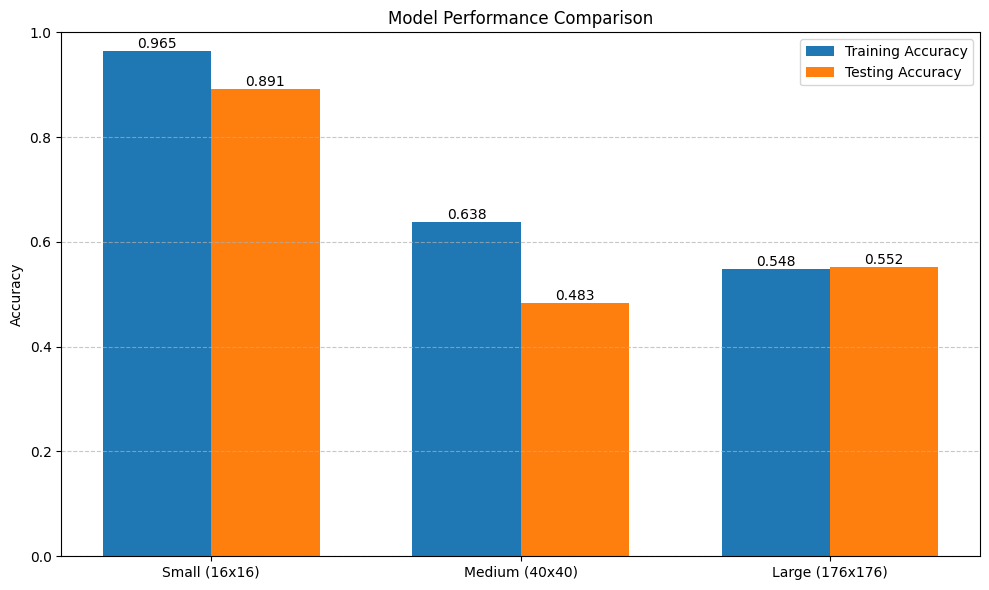

In [ ]:
models = ['Small (16x16)', 'Medium (40x40)', 'Large (176x176)']

# Get these values from your test results
train_acc = [0.965, 0.638, 0.548]  # Best training accuracy for each model
test_acc = [0.891, 0.483, 0.552]   # Testing accuracy from test_model results

# Set up bar chart
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, train_acc, width, label='Training Accuracy')
bar2 = plt.bar(x + width/2, test_acc, width, label='Testing Accuracy')

plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()

# Add value labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.ylim(0, 1.0)  # Set y-axis from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()